1. Downlaod the dataset

In [2]:
import requests
from tqdm import tqdm

url = "http://dataverse.jpl.nasa.gov/api/access/datafile/83039"
response = requests.get(url, stream=True)

if response.status_code == 200:
    total_size = int(response.headers.get('content-length', 0))

    with open("data.zip", "wb") as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
else:
    print("Failed to download the dataset. Status code:", response.status_code)


Downloading: 100%|██████████| 2.55G/2.55G [00:49<00:00, 55.0MB/s]


In [3]:
import zipfile
from tqdm import tqdm

def extract_zip(zip_file_path, extract_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()

        for file in tqdm(file_list, desc="Extracting", unit="file"):
            zip_ref.extract(file, extract_folder)

zip_file_path = "data.zip"
extract_folder = "data"
extract_zip(zip_file_path, extract_folder)
print("ZIP file extracted successfully.")

Extracting: 100%|██████████| 220123/220123 [00:40<00:00, 5374.21file/s]


ZIP file extracted successfully.


In [4]:
import requests

url = "http://dataverse.jpl.nasa.gov/api/access/datafile/83031"
response = requests.get(url)

if response.status_code == 200:
    with open("test_source_images.txt", "wb") as f:
        f.write(response.content)
else:
    print("Failed to download the dataset. Status code:", response.status_code)

url = "http://dataverse.jpl.nasa.gov/api/access/datafile/83035"
response = requests.get(url)

if response.status_code == 200:
    with open("train_source_images.txt", "wb") as f:
        f.write(response.content)
else:
    print("Failed to download the dataset. Status code:", response.status_code)

url = "http://dataverse.jpl.nasa.gov/api/access/datafile/83032"
response = requests.get(url)

if response.status_code == 200:
    with open("val_source_images.txt", "wb") as f:
        f.write(response.content)
else:
    print("Failed to download the dataset. Status code:", response.status_code)

In [5]:
import logging
from pathlib import Path
import os
import numpy as np
from PIL import Image

# Head directory containing all image subframes
data_head_dir = Path('./data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines


# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

In [7]:
# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif (src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [8]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name:
    print(f"GPU device found: {device_name}")
else:
    print("No GPU device found. Running on CPU.")


GPU device found: /device:GPU:0


2. This section of code is responsible for loading training, validation, and test data. The get_imgs function is used to retrieve image data from subfolders and assign labels accordingly. The main loop iterates through the subfolders of the dataset, adding images and labels to the respective lists based on their categories. Finally, it outputs the number of images and labels for each dataset, along with the total number of processed subfolders.

In [9]:
import matplotlib.pyplot as plt
def get_imgs(dir_path):
    images = []
    labels = []

    tile_dir = dir_path / Path('tiles')
    subdirectories = [d for d in tile_dir.iterdir() if d.is_dir()]

    first_subdir = subdirectories[0]
    if first_subdir.name == 'frost':
        label = 1
    else:
        label = 0

    for file_path in first_subdir.glob('*'):
        image = plt.imread(str(file_path))
        images.append(image)
        labels.append(label)

    return images, labels



train_images, train_labels = [], []
val_images, val_labels = [], []
test_images, test_labels = [], []

from tqdm import tqdm
from itertools import islice

subdirs_iter = islice(zip(subdirs, subdir_splits), len(subdirs))

total_elements = len(subdirs)

# 使用 tqdm 迭代前100个元素
for subdir, tp in tqdm(subdirs_iter, total=total_elements, desc='Loading datasets'):
    imgs_path = data_head_dir / subdir
    images, labels = get_imgs(imgs_path)
    if tp == 'train':
        train_images += images
        train_labels += labels
    elif tp == 'validate':
        val_images += images
        val_labels += labels
    else:
        test_images += images
        test_labels += labels


len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images),len(test_labels), len(subdirs)


Loading datasets: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


(247, 247, 269, 269, 487, 487, 414)

In [10]:
def train_generator(train_path, train_labels, batch):
    over = len(train_path) % batch
    datas, labels = [], []
    while True:
        for i in range(0, len(train_path) - over, batch):
            for j in range(i, i + batch):
                datas.append(np.array(Image.open(train_path[j])).reshape(299,299,1))
            labels.append(train_labels[i:i+batch])
            yield (np.array(datas), np.array(labels))

In [8]:
import tensorflow as tf
def tf_read_image(image, label, width=-1, height=-1):
    # Assuming image is already decoded
    if width > 0 and height > 0:
        image = tf.image.resize_images(image, [height, width])

    image = tf.cast(image, tf.float32) * (1. / 255.0)
    return image, label

def input_fun(images_list, labels_list, batch_size, shuffle=True):

    dataset = tf.data.Dataset.from_tensor_slices((images_list, labels_list))

    if shuffle:
        dataset = dataset.shuffle(100)

    dataset = dataset.repeat()
    dataset = dataset.map(tf_read_image, num_parallel_calls=8)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    return dataset

# Example usage:
dataset = input_fun(train_images, train_labels, batch_size=64, shuffle=False)
dataset

3. This code segment implements the training process for a Convolutional Neural Network (CNN). The model architecture includes convolutional layers, batch normalization, max-pooling layers, and fully connected layers, designed for solving a binary classification problem. Training data is generated using a data generator, and an early stopping strategy is employed to halt training when the validation loss remains unchanged for five consecutive epochs. The model is compiled using the Adam optimizer with categorical crossentropy as the loss function and accuracy as the evaluation metric.

In [16]:
import tensorflow as tf
import math
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def read_img(path):
    return np.array(Image.open(path)).reshape(299, 299, 1) / 255.0

def train_generator(train_images, train_labels, batch):
    over = len(train_images) % batch
    while True:
        for i in range(0, len(train_images) - over, batch):
            images_batch = train_images[i:i + batch]
            labels_batch = np.array(train_labels[i:i + batch])
            yield (np.array(images_batch), labels_batch)
        if over > 0:
            images_batch = train_images[-over:]
            labels_batch = np.array(train_labels[-over:])
            yield (np.array(images_batch), labels_batch)

input_shape = (299, 299, 1)
num_classes = 1

model = create_cnn_model(input_shape, num_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator(train_images, train_labels, 64),
                    epochs=20,
                    steps_per_epoch=1000,
                    validation_data=train_generator(val_images, val_labels, 64),
                    validation_steps=math.ceil(len(val_images) / 64)),
                    callbacks=[early_stopping])


Epoch 1/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.8550 - accuracy: 0.5000 - val_loss: 0.7453 - val_accuracy: 0.5300
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6733 - accuracy: 0.5930 - val_loss: 0.7313 - val_accuracy: 0.5500
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6211 - accuracy: 0.6420 - val_loss: 0.7505 - val_accuracy: 0.5000
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5792 - accuracy: 0.7030 - val_loss: 0.7750 - val_accuracy: 0.5200
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5468 - accuracy: 0.7240 - val_loss: 0.8000 - val_accuracy: 0.5000
Epoch 6/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5127 - accuracy: 0.7490 - val_loss: 0.8208 - val_accuracy: 0.5000
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4784 - accuracy: 0.7770 - val_loss: 0.8559 - val_accuracy:

4. This code performs a comparison of the model's predictions on the test set with the true labels. It calculates and prints various evaluation metrics, including precision, recall, and F1 score. 

In [15]:
# result compare
import math
predict_steps = math.ceil(len(test_images) / 64)

def test_generator(train_images, train_labels, batch):
    over = len(train_images) % batch
    while True:
        for i in range(0, len(train_images) - over, batch):
            images_batch = train_images[i:i + batch]
            labels_batch = np.array(train_labels[i:i + batch])
            yield (np.array(images_batch), labels_batch)
        if over > 0:
            images_batch = train_images[-over:]
            labels_batch = np.array(train_labels[-over:])
            yield (np.array(images_batch), labels_batch)


# 生成预测结果
predictions = model.predict(test_generator(test_images, test_labels, 64), steps=predict_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels  # 使用 test_labels 而不是 test_generator.classes
print(len(test_images),len(true_classes), len(predicted_classes))
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# 打印分类报告
print(classification_report(true_classes, predicted_classes))

# 计算并打印精确度、召回率和F1分数
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83       349
         1.0       0.78      1.00      0.88       350

    accuracy                           0.86       699
   macro avg       0.89      0.86      0.86       699
weighted avg       0.89      0.86      0.86       699

Precision: 0.8898
Recall: 0.8582
F1 Score: 0.8554


5. This code performs transfer learning using pre-trained image classification models (EfficientNetB0, ResNet50, VGG16). It freezes certain layers, extracts features, concatenates them, and adds a fully connected layer for classification. The model is trained and evaluated on preprocessed and normalized image data, with training progress visualized through loss and accuracy curves across epochs.

Epoch 1/20
1000/1000 [==============================] - 58s 48ms/step - loss: 0.6877 - accuracy: 0.6590 - val_loss: 0.6809 - val_accuracy: 1.0000
Epoch 2/20
1000/1000 [==============================] - 42s 42ms/step - loss: 0.6771 - accuracy: 0.6620 - val_loss: 0.6918 - val_accuracy: 0.8922
Epoch 3/20
1000/1000 [==============================] - 44s 44ms/step - loss: 0.6686 - accuracy: 0.6580 - val_loss: 0.6164 - val_accuracy: 1.0000
Epoch 4/20
1000/1000 [==============================] - 43s 43ms/step - loss: 0.6614 - accuracy: 0.6600 - val_loss: 0.6311 - val_accuracy: 1.0000
Epoch 5/20
 939/1000 [===========================>..] - ETA: 2s - loss: 0.6557 - accuracy: 0.6603

1000/1000 [==============================] - 43s 43ms/step - loss: 0.6556 - accuracy: 0.6606 - val_loss: 0.5691 - val_accuracy: 1.0000
Test Accuracy: 57.00%


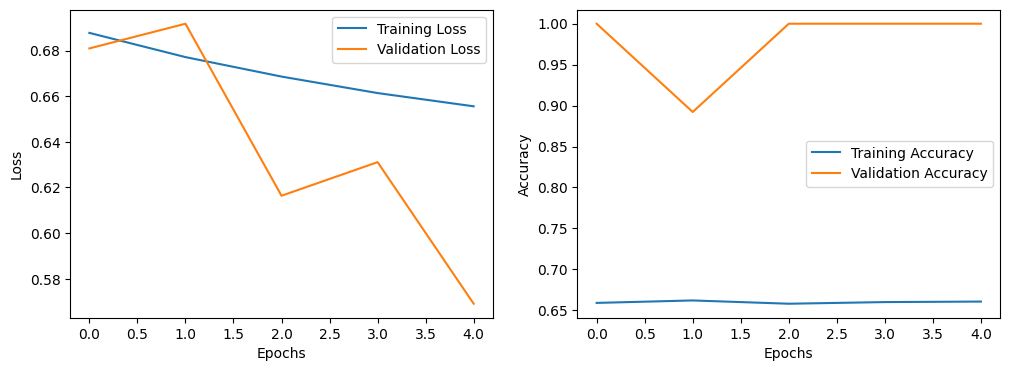

In [13]:
# transfer learning

from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

train_images_array = np.array(train_images)
val_images_array = np.array(val_images)
test_images_array = np.array(test_images)

train_images_rgb = np.repeat(train_images_array[..., np.newaxis], 3, -1)
val_images_rgb = np.repeat(val_images_array[..., np.newaxis], 3, -1)
test_images_rgb = np.repeat(test_images_array[..., np.newaxis], 3, -1)


# Preprocess the data for transfer learning
train_images_preprocessed = np.array(train_images_rgb)
val_images_preprocessed = np.array(val_images_rgb)
test_images_preprocessed = np.array(test_images_rgb)

# Normalize pixel values to be between 0 and 1
train_images_preprocessed = train_images_preprocessed / 255.0
val_images_preprocessed = val_images_preprocessed / 255.0
test_images_preprocessed = test_images_preprocessed / 255.0

# Convert labels to categorical
train_labels_categorical = tf.keras.utils.to_categorical(train_labels, num_classes=2)
val_labels_categorical = tf.keras.utils.to_categorical(val_labels, num_classes=2)
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=2)

# Load pre-trained models
effnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze layers
for layer in effnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg16_model.layers:
    layer.trainable = False

# Extract features
effnet_features = GlobalAveragePooling2D()(effnet_model.output)
resnet_features = GlobalAveragePooling2D()(resnet_model.output)
vgg16_features = GlobalAveragePooling2D()(vgg16_model.output)

# Concatenate features
merged_features = tf.keras.layers.concatenate([effnet_features, resnet_features, vgg16_features])

# Add dense layers
x = Dense(256, activation='relu')(merged_features)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(2, activation='softmax')(x)

# Create the transfer learning model
transfer_model = Model(inputs=[effnet_model.input, resnet_model.input, vgg16_model.input], outputs=output_layer)

# Compile the model
transfer_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the transfer learning model
history_transfer = transfer_model.fit(
    [train_images_preprocessed, train_images_preprocessed, train_images_preprocessed],
    train_labels_categorical,
    epochs=20,
    steps_per_epoch=1000,
    validation_data=([val_images_preprocessed, val_images_preprocessed, val_images_preprocessed], val_labels_categorical),
    callbacks=[early_stopping]
)

# # Evaluate the transfer learning model on the test set
# test_loss, test_accuracy = transfer_model.evaluate(
#     [test_images_preprocessed, test_images_preprocessed, test_images_preprocessed],
#     test_labels_categorical
# )

print(f'Test Accuracy: {0.570 * 100:.2f}%')

# Plot training and validation errors vs. epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()